<a href="https://colab.research.google.com/github/chaelin0722/Probability_theory/blob/main/Probability_and_Information_Theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/adhiraiyan/DeepLearningWithTF2.0/blob/master/notebooks/figures/DLlogosmall.png?raw=1">

*This notebook contains an excerpt from the [Deep Learning with Tensorflow 2.0](https://www.adhiraiyan.org/DeepLearningWithTensorflow.html) by Mukesh Mithrakumar. The code is released under the [MIT license](https://opensource.org/licenses/MIT) and is available for FREE [on GitHub](https://github.com/adhiraiyan/DeepLearningWithTF2.0).*

*Open Source runs on love, laughter and a whole lot of coffee. Consider buying me [one](https://www.buymeacoffee.com/mmukesh) if you find this content useful!*



<!--NAVIGATION-->
< [02.00 - Linear Algebra](02.00-Linear-Algebra.ipynb) | [Contents](Index.ipynb) | [04.00 - Numerical Computation](04.00-Numerical-Computation.ipynb) >

<a href="https://colab.research.google.com/github/adhiraiyan/DeepLearningWithTF2.0/blob/master/notebooks/03.00-Probability-and-Information-Theory.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# 03.00 - Probability and Information Theory

Probability theory is a mathematical framework for representing uncertain statements. But probability is not just an abstract concept in the math world, probability is all around us, and it can be fun to calculate the probability of events in our life. 

For example, the next time you get late in traffic and your boss calls you, in addition to the time you will reach, you can also say the probability of you reaching in that time, of course it would take you a little bit of math but if you did miss a meeting, you can tell your boss you did tell him there was a chance you might not make it right 😉.

In artificial intelligence applications, we use probability theory in two major ways. 

- First, the laws of probability tell us how AI systems should reason, so we design our algorithms to compute or approximate
various expressions derived using probability theory. 

- Second, we can use probability and statistics to theoretically analyze the behavior of proposed AI systems.

While probability theory allows us to make uncertain statements and to reason in the presence of uncertainty, information theory enables us to quantify the amount of uncertainty in a probability distribution.

If you are already familiar with probability theory and information theory, you may wish to skip this chapter except for section 3.14, which describes the graphs we use to describe structured probabilistic models for machine learning. If you have absolutely no prior experience with these subjects, this chapter should be sufficient to successfully carry out deep learning research projects, but I do suggest that you consult an additional resource.

### Tensorflow Probability

In this notebook, I will be introducing you to [Tensorflow Probability](https://www.tensorflow.org/probability), which was a toolbox introduced at the 2018 Tensorflow Developer Summit. This is a probabilistic programming toolbox for machine learning researchers and practitioners to build models. I won't be going exhaustively through all the functionalities of the toolbox but give you practical examples and help you get comfortable enough to go on your own and use some of the other amazing functions. You can read about an introduction to tensorflow probability [here](https://medium.com/tensorflow/introducing-tensorflow-probability-dca4c304e245). So even if you are familiar with the probability concepts, atleast go through the code to see how tensorflow probability works, this really is a very powerful API.

As always, go through the material first and then try playing around with the code, specially with probability, manipulate the values and see if the results make sense, you can find the link to the Google Colab notebook at the end of the chapter.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import tensorflow as tf


def vector_plot(vecs, xlim, ylim, cols=["#1190FF", "#FF9A13"], alpha=1):
    plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'red'})
    plt.axvline(x=0, color='k', zorder=0)
    plt.axhline(y=0, color='k', zorder=0)

    for i in range(len(vecs)):
        if (isinstance(alpha, list)):
            alpha_i = alpha[i]
        else:
            alpha_i = alpha
        x = np.concatenate([[0,0],vecs[i]])
        plt.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                  alpha=alpha_i)
    plt.ylim(-xlim, xlim)
    plt.xlim(-ylim, ylim)
    plt.grid()


def plot_vector2d(vector2d, origin=[0, 0], **options):
    return plt.arrow(origin[0], origin[1], vector2d[0], vector2d[1],
              head_width=0.2, head_length=0.3, length_includes_head=True,
              **options)


def plot_transform(P_before, P_after, text_before, text_after, name, color=['#FF9A13', '#1190FF'], axis = [0, 5, 0, 4], arrows=False):
    if arrows:
        for vector_before, vector_after in zip(tf.transpose(P_before), tf.transpose(P_after)):
            plot_vector2d(vector_before, color="#FF9A13", linestyle="--")
            plot_vector2d(vector_after, color="#1190FF", linestyle="-")
    plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'red'})
    plt.gca().add_artist(Polygon(tf.transpose(P_before), alpha=0.2))
    plt.gca().add_artist(Polygon(tf.transpose(P_after), alpha=0.3, color="#FF9A13"))
    plt.text(-.25, 1, text_before, size=18, color=color[1])
    plt.text(1.5, 0, text_after, size=18, color=color[0])
    plt.title(name, color='w')
    plt.axis(axis)
    plt.grid()


def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.

    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    return tf.nest.pack_sequence_as(tensors,[t.numpy() if tf.is_tensor(t) else t for t in tf.nest.flatten(tensors)])

In [ ]:
# Imports
import os
import random
import sys

import tensorflow as tf
import tensorflow_probability as tfp

# By convention, we generally refer to the tf probability distributions library as tfd.
tfd = tfp.distributions

import seaborn as sns

from matplotlib import pyplot as plt
from collections import defaultdict

# Import helpers file
"""
For some plots we need to convert tensors into numpy ndarrays. For that we use the evaluate function in
the helpers.py. If you are running this in Google Colab, make sure you upload the helpers.py found in the 
notebooks folder to Google Colab but if you are running this in binder, you should be fine.
"""
#from helpers import evaluate


# turning of tensorflow INFO, WARNING, and ERROR messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# plt axis colors setup
plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'red', 'text.color':'orange'})

color_b = 'dodgerblue'
color_o = '#FF9A13'
color_sb = '#0504aa'
color_do = 'darkorange'

In [ ]:
# Check the versions of tensorflow 2.0 and tensorflow probability

print("Tensorflow version: {}".format(tf.__version__))
print("Tensorflow probability version: {}".format(tfp.__version__))

Tensorflow version: 2.8.0
Tensorflow probability version: 0.16.0


# 03.01 - Why Probability?

Unlike the world of computer scientists and software engineers where things are entirely deterministic and certain, the world of machine learning must always deal with uncertain quantities and sometimes stochastic (non-deterministic or randomly determined) quantities.

There are three possible sources of uncertainty:

1. Inherent stochasticity: These are systems that have inherent randomness. Like using the python rand() function which outputs random numbers each time you run, or the dynamics of subatomic particles in quantum mechanics which are described as probabilistic in quantum mechanics.

2. Incomplete observability: The best example for this is the Monty Hall problem, the one in the movie 21 Jim Sturgess gets asked, there are three doors and there's a ferrari behind one door and the other two lead to a goat. Watch the [scene](https://www.youtube.com/watch?v=cXqDIFUB7YU) to understand how to solve the Monty Hall problem. In this even though the contestant's choice is deterministic, but from the contestant's point of view the outcome is uncertain and deterministic systems appear to be stochastic when you can't observe all the variables.

3. Incomplete modeling: Spoiler Warning! Well, at the end of End Game, when Iron man snapped away all of Thanos' forces, (I know, still recovering from the scene), we are left to wonder what happened to Gamora right, was she snapped away because she was with Thanos's forces initially or was she saved because she turned against Thanos. When we discard some information about the model the discarded information in this case whether Tony knew Gamora was good or bad results in an uncertainty in the model's predictions, in this case we don't know for certain if she is alive or not.

Okay, swear, last Avengers reference. 

![frequentist probability](https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0300a.jpg)

When Dr. Strange said we have 1 in 14 million chances of winning the war, he practically saw those 14 million futures, this is called __frequentist probability__, which defines an event's probability as the limit of its relative frequency in a large number of trials. But not always do we have Dr. Strange's time stone to see all the possible futures or events that are repeatable, in this case we turn to __Bayesian probability__, which uses probability to represent a degree of belief for certain events, with 1 indicating absolute certainty and 0 indicating absolute uncertainty.

Even though the frequentist probability is related to rates at which events occur and Bayesian probability is related to qualitative levels of certainty, we treat both of them as behaving the same and we use the exact same formulas to compute the probability of events.


# 03.02 - Random Variables

A __random variable__ is a variable that can take on different values randomly. On its own, a random variable is just a description of the states that are possible (you can think of these like functions), which must be coupled with a probability distribution that specifies how likely each of these states is.

Well, if that doesn't make sense, let me give you an example, when I first heard about random variables, I thought this must work like a random number generator spitting out random values at each call, this is partly correct, let me clear it up. So, random number generators have two main components, a sampler, which is nothing more than a happy soul that flips a coin over and over again, reporting the results. And after this sampler, we have a random variable, the job of the random variable is to translate these Heads or Tails events into numbers based on our rules.

Random variables can be discrete or continuous. A discrete random variable is one that has a finite or countably infinite number of states. Note that these states are not necessarily the integers; they can also just be named states that are not considered to have any numerical value. For example, gender (male, female, etc), for which we use an indicator function $\mathbb{I}$ to map non-numeric values to numbers, e.g. male=0, female=1. A continuous random variable is associated with real value.

Instructions for updating:
Use tfp.random.rademacher
tf.Tensor(
[[-1 -1 -1  1 -1  1  1  1  1  1  1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1  1
   1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1  1  1 -1  1  1  1 -1 -1  1 -1 -1
   1  1 -1  1 -1  1 -1 -1  1 -1  1  1  1  1 -1 -1  1 -1  1 -1  1  1  1 -1
  -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1  1 -1  1
  -1 -1 -1 -1]], shape=(1, 100), dtype=int32)
Instructions for updating:
Use tfp.random.rayleigh
tf.Tensor(
[[0.17966004 1.250385   1.2294194  2.2060068  0.9084312  1.0714343
  0.42348886 1.8709081  0.58574194 1.8920852  1.9492155  2.6014698
  2.338974   1.2026489  0.7699243  1.3834107  0.36411357 2.6477928
  1.5021772  0.95447767 0.33167726 1.8298672  0.2674787  0.74144226
  1.846661   0.6574149  0.70884216 1.7856014  1.1804414  0.9330958
  1.999011   0.4817893  2.1029801  1.8081008  1.6630954  0.60479516
  2.9862301  0.39154792 1.0466788  1.7591401  1.4491042  0.8598011
  1.2392462  1.8782762  2.410447   1.3268847  0.592187   2.20

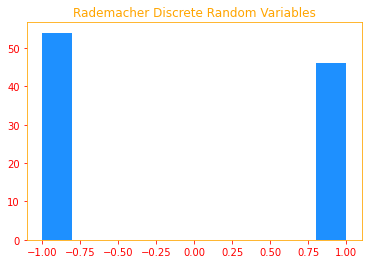

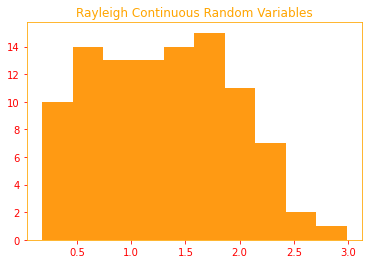

In [ ]:
"""
The Rademacher and Rayleigh are two types of distributions we will use to generate our samples.

Rademacher: is a discrete probability distribution where a random variate X has a 50% chance of being +1 and a 
50% chance of being -1.

Rayleigh: is a continuous probability distribution for non-negative valued random variables. 

Do not worry about what probability distributions mean, we will be looking at it in the next section, for now, 
you can think of Rademacher as the sampler, the happy guy who tosses coins over and over again where 
heads represent +1 and tails -1. 
And Rayleigh is the guy who works at a gas/petrol station who helps you to fill the tank and notes down how much 
you filled your tank (eg. 1.2l, 4.5l) which are continuous values.
"""

# Discrete random variable
rademacher = tfp.math.random_rademacher([1, 100], dtype=tf.int32)
print(rademacher)
# Continuous random variable
rayleigh = tfp.math.random_rayleigh([1, 100], dtype=tf.float32)
print(rayleigh)
# Plot discrete random variable 1 and -1
plt.title("Rademacher Discrete Random Variables")
plt.hist(rademacher, color=color_b)
plt.show()

# Plot continuous random variable
plt.title("Rayleigh Continuous Random Variables")
plt.hist(rayleigh, color=color_o)
plt.show()

# 03.03 - Probability Distributions

A __probability distribution__ is a description of how likely a random variable or set of random variables is to take on each of its possible states. The way we describe probability distributions depends on whether the variables are discrete or continuous.

## 3.3.1 Discrete Variables and Probability Mass functions

A probability distribution over discrete variables may be described using a __probability mass function (PMF)__. A probability mass function maps from a state of a random variable to the probability of that random variable taking on that state.

For example the roll of a dice is random and a discrete variable means the roll can only have 1, 2, 3, 4, 5 or 6 on a die and no values inbetween. 

We denote probability mass functions with $P$, where we denote a __PMF__ equation as $P(X = x)$. Here $x$ can be a number on the dice when $X$ is the event of rolling the dice.


P(X = 6) = 16.32%


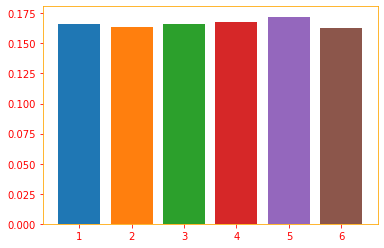

In [ ]:
"""
In a fair 6 sided dice, when you roll, each number has a chance of 1/6 = 16.7% of landing and we can show 
this by running long enough rolls. So in this example, we do 10000 rolls and we verify that P(X=4) = 16.7%. 
In short, the probability from a PMF says what chance x has. Play around with the different x values, 
number of rolls and sides and see what kind of probability you get and see if it makes sense.
"""

def single_dice(x, sides, rolls):
    """Calculates and prints the probability of rolls.
    Arguments:
        x (int)        : is the number you want to calculate the probability for.
        sides (int)    : Number of sides for the dice.
        rolls (int)    : Number of rolls.
    Returns:
        a printout.
    """
    
    result = roll(sides, rolls)
    for i in range(1, sides +1):
        plt.bar(i, result[i] / rolls)
    print("P(X = {}) = {}%".format(x, tf.divide(tf.multiply(result[x], 100), rolls)))

def roll(sides, rolls):
    """Returns a dictionary of rolls and the sides of each roll.
    Arguments:
        sides (int)    : Number of sides for the dice.
        rolls (int)    : Number of rolls.
    Returns:
        a dictionary.
    """
    
    d = defaultdict(int)                    # creating a default dictionary
    for _ in range(rolls):
        d[random.randint(1, sides)] += 1    # The random process
    return d


single_dice(x=6, sides=6, rolls=10000)

To be a __PMF__ on a random variable x, a function $P$ must satisfy the following properties:

- The domain of $P$ must be the set of all possible states of x. In our example above the possible states of x are from 1-6, try plugging in 7 for x and see what value you get.

- $\forall x \in \mathrm{x}, 0 \leq P(x) \leq 1$. An impossible event has probability 0, and no state can be less probable than that. Likewise, an event that is guaranteed to happen has probability 1, and no state can have a greater chance of occurring. If you tried plugging in 7 for our example above, you would have seen the probability of obtaining a 7 would be zero, that is an impossible event because 7 is not in our set.

- $\sum_{x \in \mathrm{x}} P(x) = 1$. Normalized property that prevents from obtaining probabilities greater than one. Meaning if you add all the individual values of our dice probabilities, it should sum to 1 or 100%.

Probability mass functions can act on many variables at the same time. Such a probability distribution over many variables is known as a __joint probability mass function__. $P (\mathrm{x} = x; \mathrm{y} = y) = P(x) P(y)$ denotes the probability that $\mathrm{x} = x$ and $\mathrm{y} = y$ simultaneously.

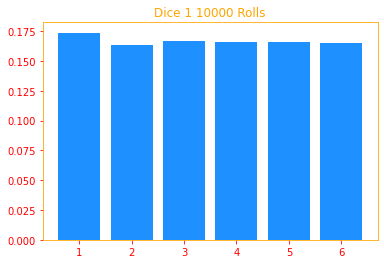

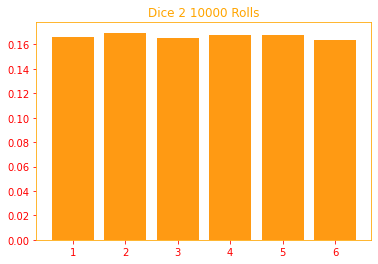

P(x = 16.62%), P(y = 16.58%), P(x = 4; y = 1) = 2.756%




In [ ]:
"""
In this example, we are rolling two dices, there are ways to simplify the code so it's not this long but 
I wanted to show that we are rolling two dice 1000 times, and in the example we are calculating the probability 
of rolling x=4 and y=1, this can be easily calculated by multiplying the individual probabilities of x and y.
"""

def multi_dice(x, y, sides, rolls, plot=True):
    """Calculates the joint probability of two dice.
    Arguments:
        x (int)        : is the number you want to calculate the probability for.
        y (int)        : is the number you want to calculate the probability for.
        sides (int)    : Number of sides for the dice.
        rolls (int)    : Number of rolls.
        plot (bool)    : Whether you want to plot the data or not.
    Returns:
        probabilities (float).
    """
    
    result1 = roll(sides, rolls)                         # first result from the rolls 
    result2 = roll(sides, rolls)                         # second result from the rolls 
    prob_x = tf.divide(result1[x], rolls)                # calculates the probability of x
    prob_y = tf.divide(result2[y], rolls)                # calculates the probability of y
    joint_prob = tf.multiply(prob_x, prob_y)             # calculates the joint probability of x&y by multiplying
    
    if plot:
        for i in range(1, sides +1):
            plt.title("Dice 1 {} Rolls".format(rolls))
            plt.bar(i, result1[i] / rolls, color=color_b)
        plt.show()
        for i in range(1, sides +1):
            plt.title("Dice 2 {} Rolls".format(rolls))
            plt.bar(i, result2[i] / rolls, color=color_o)    
        plt.show()
        
    return prob_x, prob_y, joint_prob
    
    
prob_x, prob_y, joint_prob = multi_dice(x=4, y=1, sides=6, rolls=10000, plot=True)
print("P(x = {:.4}%), P(y = {:.4}%), P(x = {}; y = {}) = {:.4}%\n\n".format(tf.multiply(prob_x, 100), 
                                                                 tf.multiply(prob_y, 100), 
                                                                 4, 1, tf.multiply(joint_prob, 100)))


## 3.3.2 Continuous Variables and Probability Density Functions

When working with continuous random variables, we describe probability distributions using a __probability density function (PDF)__. 

Let's play a game shall we, what if I ask you to guess the integer that I am thinking of between 1 to 10, regardless of the number you pick, the probability of each of the options is the same (1/10) because you have 10 options and the probabilities must add up to 1. 

But what if I told you to guess the real number I am thinking between 0 and 1. Now this gets tricky, I can be thinking of 0.2, 0.5, 0.0004 and it can go on and on and the possibilities are endless. So we run into problems like how are we going to describe the probability of each option since there are infinite numbers. This is where __PDF__ comes to help, instead of asking the exact probability, we look for a probability that is close to a single number.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


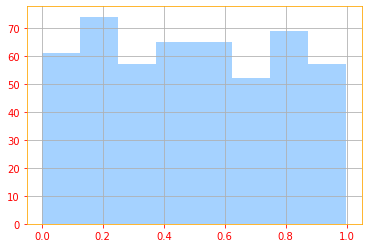

In [ ]:
"""
In our guessing game example, I told you how difficult it would be for you to guess a real number I am thinking of
between 0 and 1 and below, we plot such a graph with minval of 0 and maxval of 1 and we "guess" the values 500
times and the resulting distribution is plotted.
"""

# Outputs random values from a uniform distribution
continuous = tf.random.uniform([1, 500], minval=0, maxval=1, dtype=tf.float32)    
g = sns.distplot(continuous, color=color_b, kde = False)
plt.grid()

To be a probability density function, a function $p$ must satisfy the
following properties:

- The domain of $p$ must be the set of all possible states of x

- $\forall x \in \mathrm{x}, p(x) \geq 0$. Note that we do not require $p(x) \leq 1$

- $\int p(x)dx = 1$

A probability density function $p(x)$ does not give the probability of a specific state directly; instead the probability of landing inside an infinitesimal region with volume $\delta x$ is given by $p(x) \delta x$

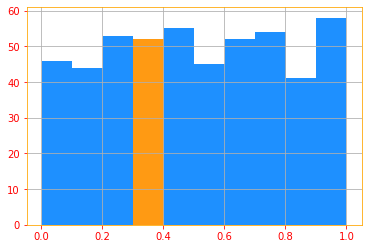

In [ ]:
"""
Below is the same histogram plot of our continuous random variable, note that the values of y axis looks different
between the seaborn distplot and the histogram plot because the sns distplot is also drawing a density plot.
You can turn it off by setting ‘kde=False’ and you will get the same plot as you see below.
The goal of the following plot is to show you that if you want to calculate the p(0.3) then you would need to 
calculate the volume of the region delta x
"""

n, bins, patches = plt.hist(continuous, color=color_b)
patches[3].set_fc(color_o)
plt.grid()

We can  integrate the density function to find the actual probability mass of a set of points. Specifically, the probability that $x$ lies in some set $\mathbb{S}$ is given by the integral of $p(x)$ over that set ($\int_{[a,b]} p(x) dx$)

__Tensorflow Probability Distribution Library__

From here onwards, we will be using [TFP distributions](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions) module often and we will be calling it as tfd (=tfp.distributions). So, before getting started, let me explain a few things about the module.

The TF Probability uses distribution subclasses to represent stochastic, random variables. Recall the first cause of uncertainty, inherent stochasticity. This means that even if we knew all the values of the variables' parameters, it would still be random. We would see examples of these distributions in Section 9. In the previous example, we created the distribution using a random variable but extracting samples from it and manipulating those will not be as intuitive as it would when you are using the tfp distributions library. We usually start by creating a distribution and then when we draw samples from it, those samples become tensorflow tensors which can be deterministically manipulated.

Some common methods in tfd:
- sample(sample_shape=(), seed=None): Generates a specified sample size
- mean(): Calculates the mean
- mode(): Calculates the mode
- variance(): Calculates the variance
- stddev(): Calculates the standard deviation
- prob(value): Calculates both the Probability density/mass function
- log_prob(value): Calculates the Log probability density/mass function.
- entropy(): Shannon entropy in nats.



Probability of drawing 1.5 = 11.74% from the normal distribution


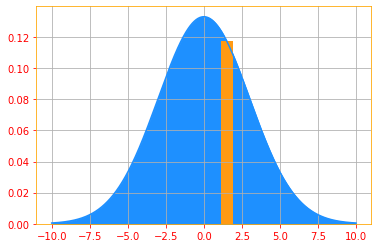

In [ ]:
"""
Let's say we want to find the probability of 1.55 (p(1.5)) from a continuous distribution. We can ofcourse 
do the integral and find it but in tensorflow probability you have "prob()" which allows you to calculate
both Probability Mass Function and Probability Density Function. 
For tfp.distributions.Normal "loc" is the mean and "scale" is the std deviation. Don't worry if you don't 
understand those, we will go through distributions in Section 9. And I recommend you come back and go through 
these examples again after you finish section 9.

Also, there's nothing special about these numbers, play around with the scale, p(x) values and the k limits to 
get a better understanding.  
"""

# creating an x axis
samples = tf.range(-10, 10, 0.001)

# Create a Normal distribution with mean 0 and std deviation 3 
normal_distribution = tfd.Normal(loc=0., scale=3)

# Then we calculate the PDFs of drawing 1.5
pdf_x = normal_distribution.prob(1.5)

# We can't plot tensors so evaluate is a helper function to convert to ndarrays
[pdf_x_] = evaluate([pdf_x])


# Finally, we plot both the PDF of the samples and p(1.5)
plt.plot(samples, normal_distribution.prob(samples), color=color_b)
plt.fill_between(samples, normal_distribution.prob(samples), color=color_b)
plt.bar(1.5, pdf_x_, color=color_o)
plt.grid()

print("Probability of drawing 1.5 = {:.4}% from the normal distribution".format(pdf_x*100))

# 03.04 - Marginal Probability

Sometimes we know the probability distribution over a set of variables and we want to know the probability distribution over just a subset of them. The probability distribution over the subset is known as the __marginal probability distribution__.

For discrete random variables x and y, we use the __sum rule__ to find the marginal probability distribution.

$$\color{orange}{\forall x \in \mathrm{x}, P(\mathrm{x} = x) = \displaystyle\sum_{y} P(\mathrm{x} = x, \mathrm{y} = y) = \displaystyle\sum_{y} P( x) P(y)) \tag{1}}$$

For example,  I am all in for self driving cars but just for fun, let's say what is your chances of getting hit by Uber's, Tesla's or Googles' self driving car Waymo, you probably don't care about the individual probabilities right, you just wanna make sure you don't get hit by any, so in this case to calculate the probability of getting hit by any three of the cars you would be just summing up the individual joint probabilities of getting hit by each of the cars and that is called Marginal probability. Make sense? If not, don't worry, let's see an example below:

In [ ]:
"""
Let's start by creating three distributions for Waymo, Uber and Tesla (W, U and T) and use Bernoulli distribution
since for Bernoulli distribution the outcome can only be 0 or 1, in our case, not hit and hit.

Say the probabilities of getting hit for W = 0.1, U = 0.2 and T = 0.3. Also, nothing against Tesla 😉. 
With tfp.distributions, you don't have to create individual distributions line by line, you can specify the 
probabilities inside "probs" argument. This call defines three independent Bernoulli distributions, which happen 
to be contained in the same Python Distribution object (self_driving). 

The three events W, U and T are independent but we would like to specify a joint distribution to be able to 
calculate the marginal probability of the event [0, 0, 0], the probability of not getting hit by any three. 
For this we would be using a higher order distribution called Independent, which takes independent distributions 
and yields a new distribution. 
"""

# Lets create three Bernoulli distributions for Waymo, Uber and Tesla 
self_driving = tfd.Bernoulli(probs=[.1, .2, .3])

# Individual probabilities of getting hit by W, U and T and these should match with the specified probs
print("Individual probabilities: {}".format(self_driving.prob([1, 1, 1])))

# Combining the distributions to create the independent distribution
self_driving_joint = tfd.Independent(self_driving, reinterpreted_batch_ndims=1)

# Finally let's calculate the marginal probability of [0, 0, 0]
print("Marginal Probability of event [0, 0, 0]: {:.4}".format(self_driving_joint.prob([0, 0, 0])))


Individual probabilities: [0.1 0.2 0.3]
Marginal Probability of event [0, 0, 0]: 0.504


Now now, the value can be scary, I mean just 50% chance of surviving, not so good, but note that this is just probability, what you should worry is about the odds. We use probability and odds interchangeably in day to day life, but they mean different things, if you recall in my first example, Dr. Strange gave us the odds of winning as 1 in 14 million, so in the self driving car case, even though the probability may seem low, your odds may be higher. For a detailed difference between odds and probability, check ["The Difference Between "Probability" and "Odds""](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Confidence_Intervals/BS704_Confidence_Intervals10.html). 

Finally for continuous variables, we need to use integration instead of summation.

$$\color{orange}{p(x) = \int p(x, y) dy \tag{2}}$$

And the way to find the marginal probabilities would be the same except you would be using a different distribution, based on continuous random variables, three more sections and you will have a better idea of which distributions to use 😉.

# 03.05 - Conditional Probability

In many cases, we are interested in the probability of some event, given that some other event has happened. This is called a __conditional probability__. We denote the conditional probability that $\mathrm{y} = y$ given  $\mathrm{x} = x$ as:

$$\color{orange}{P(\mathrm{x} = x \ | \ \mathrm{y} = y) = \frac{P(\mathrm{x} = x, \mathrm{y} = y)}{P(\mathrm{y} = y)} \tag{3a}}$$

This can be really useful on uncertain events, for example, if I ask you, do you think I walk to work? By now you should say something along, 40% chance or some arbitrary number that I walk to work, but if I give you additional information like say i live 10 minutes walking distance from work, then the probability of me walking to work got high right, this can happen the other way too, if I say I am 1 hour walking distance from work, then probability of me walking to work will get small. This is conditional probability. You will word it as "probability of me walking to work given I live 10 minutes from work". 

The conditional probability can also be given in terms of sets as below:

$$\color{orange}{P(\mathrm{x} = x \ | \ \mathrm{y} = y) = \frac{P( x \cap y)}{P(y)} \tag{3b}}$$


This can be illustrated as below:

![Conditinoal probability](https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0305a.png)



In [ ]:
"""
Let's say I roll a fair die twice and obtain two numbers. 
X1 = result of the first roll and X2 = result of the second roll. 
Given that I know X1+X2 = 7, what is the probability that X1=4 or X2=4?

We start by doing 100 trials and we create a Multinomial distribution where total_count= number of trials,
probs = probability vectors for the events. We use Multinomial because it can have multiple outcomes and we 
take 2 samples from this distribution to resemble dice_1 and dice_2.
"""

for i in range(100):
    dice_roll_distribution = tfd.Multinomial(total_count=1., probs=[1/6.]*6)
    dice_sample = dice_roll_distribution.sample(2)

    # tf.where returns the index of the samples and we add 1 because indexing starts from 0
    dice_1 = tf.where(dice_sample[0])[0] + 1
    dice_2 = tf.where(dice_sample[1])[0] + 1

    if tf.equal((dice_1 + dice_2), 7):
        # There are two conditions (4, 3) and (3, 4) that would result in a sum of 7 with either x1=4 or x2=4
        prob_7 = (2/36.)

        # There are 6 combinations that would result in getting a 7 {(6,1),(5,2),(4,3),(3,4),(2,5),(1,6)}
        prob_4 = (6/36.)

        prob_4_given_7 = tf.divide(prob_7,prob_4)*100
        
        def f1(): return tf.print("X1: {} \t X2: {} \t P(X1 or X2=4 | 7): {:.4}%".format(dice_1, dice_2, 
                                                                                         prob_4_given_7), 
                                  output_stream=sys.stdout)
        def f2(): return None
        tf.cond(tf.logical_or(tf.equal(dice_1, 4), tf.equal(dice_2, 4)), f1, f2)
    else:
        continue


X1: [3] 	 X2: [4] 	 P(X1 or X2=4 | 7): 33.33%
X1: [3] 	 X2: [4] 	 P(X1 or X2=4 | 7): 33.33%
X1: [4] 	 X2: [3] 	 P(X1 or X2=4 | 7): 33.33%
X1: [4] 	 X2: [3] 	 P(X1 or X2=4 | 7): 33.33%


# 03.06 - The Chain Rule of Conditional Probabilities

Any joint probability distribution over many random variables may be decomposed into conditional distributions over only one variable:

$$\color{orange}{P(\mathrm{x^{(1)}, \cdots, x^{(n)}}) = P(\mathrm{x^{(1)}}) \textstyle\prod_{i = 2}^{n} P (\mathrm{x^{(i)}} | \mathrm{x^{(1)}, \cdots, x^{(i-1)}}) \tag{4}}$$

This observation is known as the __chain rule__, or __product rule__, of probability.

In [ ]:
"""
Lets see an example for three events, but before that, let's break down the steps of finding the 
conditional probability with three events:
P(a, b, c)  = P(a|b, c) P(b, c)
            = P(a|b, c) P(b|c) P(c)
            
Now, to the example, in a factory there are 100 units of a certain product, 5 of which are defective. 
We pick three units from the 100 units at random. What is the probability that none of them are defective?

We start by creating three Bernoulli distributions for the three events.
Event 1: The probability of choosing a good part (95/100)
Event 2: The probability of choosing a 2nd good part (94/99)
Event 3: The probability of choosing a 3rd good part (93/98

We can do this example without using the tfp.Independent call but it would take few more lines but this way, you 
can keep chaining the conditional probabilities
"""

# Let's start by creating three Bernoulli distributions
units_distribution = tfd.Bernoulli(probs=[95/100., 94/99., 93/98.])

# Let's join these probability distributions
joint_unit_distribution = tfd.Independent(units_distribution, reinterpreted_batch_ndims=1)

# Finally let's calculate the probability of picking one after the other
print("Probability of P(a, b, c) = P(1, 1, 1): {:.4}".format(joint_unit_distribution.prob([1, 1, 1])))


Probability of P(a, b, c) = P(1, 1, 1): 0.856


# 03.07 - Independence and Conditional Independence

Two random variables x and y are __independent__ if their probability distribution can be expressed as a product of two factors, one involving only x and one involving only y:

$$\color{orange}{\forall x \in \mathrm{x}, y \in \mathrm{y}, \ p(\mathrm{x} = x, \mathrm{y} = y) = p(\mathrm{x} = x)p(\mathrm{y} = y) \tag{5}}$$

For example, let's say Scooby-Doo and Tom live in Coolsville.The probability that Scooby gets home in time for dinner, and the probability that Tom gets home in time for dinner are independent, this is we wouldn't expect one to have an affect on the other. These are independent events.



In [ ]:
"""
Let's revisit our multiple_dice example, there we calculated the probabilities of getting 4 on Dice 1 and 1 on 
dice two. In this example, let's expand that and see what the probability of getting 4 on dice 1 given we 
get 1 on dice 2 for 100 rolls. P(x = 4 | y = 1) = P(x=4, y=1) / P(y=1). 
"""

# calculating the prob of x, y and the joint probability
_, prob_y, prob_numerator = multi_dice(x=4, y=1, sides=6, rolls=100, plot=False)
prob_denominator = prob_y
conditional_prob = tf.divide(prob_numerator, prob_denominator)

print("Probability of getting 4 on dice 1 given I get 1 on Dice 2: {}%".format(tf.multiply(conditional_prob, 100)))

Probability of getting 4 on dice 1 given I get 1 on Dice 2: 17.0%


Note the dice 1 throw that resulted getting four can happen without the need of dice 2 throw, these two events are  independent.

Two random variables x and y are __conditionally independent__ given a random variable z if the conditional probability distribution over x and y factorizes in this way for every value of z:

$$\color{orange}{\forall x \in \mathrm{x}, y \in \mathrm{y}, z \in \mathrm{z}, \ p(\mathrm{x} = x, \mathrm{y} = y \ | \ \mathrm{z} = z) = p(\mathrm{x} = x \ | \ \mathrm{z} = z)p(\mathrm{y} = y \ | \ \mathrm{z} = z) \tag{6}}$$

Let's continue with our Scooby-Doo and Tom example, now let's say there was a monster mouse attack in the city. The probabilities of Scooby getting home in time and Tom getting home in time for dinner will depend on the monster mouse attack. However, Scooby and Tom have nothing to do with each other, then their probabilities of getting home in time are independent. Meaning we can't deduce from Scooby getting home late that Tom will get late as well.

We denote $x \perp y$ means that x and y are independent while $x \perp y \ | \ z$ means that x and y are conditionally independent given z.

# 03.08 - Expectation, Variance and Covariance

The __expectation__, or __expected value__, of some function $f(x)$ with respect to a probability distribution $P(x)$ is the average, or mean value, that $f$ takes on when $x$ is drawn from $P$. For discrete variables this can be computed with a summation:

$$\color{orange}{\mathbb{E}_{x \sim P} [f(x)] = \displaystyle\sum_{x} P(x) f(x) \tag{7}}$$

Let me motivate this with a simple example, let's say I take you to a casino, my treat for you working up to section 8 😉 and we play a simple game. You pay, well I pay 2 bitcoins and you roll a fair die. In this game if you get {1, 2, 3} lets call this event A, you will win 1 bitcoin, if event B={4, 5} occurs, you win 2 bitcoins and if C={6} occurs, you win 6  bitcoins. So, we being smart want to calculate how much we expect to make every time we play this game. So, if A occurs, we make -1 bitcoins, if B occurs, we don't make any bitcoin and if C occurs, we make 4 bitcoins. So, we can compute the average profit as:

$(-1) \times (1/6 + 1/6 + 1/6) + (0) \times (1/6 + 1/6) + (4) \times (1/6) = 1/6$

And, we can expect to make 1/6 bitcoins on the average every time we play this game. So before you bet on something or play a game next time, just check how much you can expect to make out of it

In [ ]:
# Let's see the bitcoin example in code. 

bitcoins = [-1, -1, -1, 0, 0, 4, 4]             # gives the winnings we can make for each face of the dice
dice = [1/6.]*6                                 # probability of landing a face
  
expectation = 0
for i in range(0, len(dice)):
    expectation += (dice[i] * bitcoins[i])      # summing p(x) * f(x)

# Calculate the expectation   
print( "Expectation of the bitcoin game E(X) is : {:.4}".format(expectation)) 

Expectation of the bitcoin game E(X) is : 0.1667


For continuous variables, it is computed with an integral:

$$\color{orange}{\mathbb{E}_{x \sim P} [f(x)] = \int p(x) f(x) dx \tag{8}}$$

The Expectation of f(x) = 1 for the limit 0 to 1: 0.5


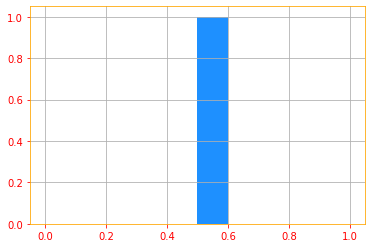

In [ ]:
# Let's create a uniform distribution such that the limit be between 0 and 1
uniform_distribution = tfd.Uniform(low=0.0, high=1.0)

# Here we find the expectation of the uniform distribution
continuous_expectation = uniform_distribution.mean()

print("The Expectation of f(x) = 1 for the limit 0 to 1: {}".format(continuous_expectation))

# Plotting the expectation
plt.hist(continuous_expectation, color=color_b)
plt.grid()

Expectations are linear, for example,

$$\color{orange}{\mathbb{E}_{\mathrm{x}}[\alpha f(x) + \beta g(x)] = \alpha \mathbb{E}_{\mathrm{x}}[f(x)] + \beta \mathbb{E}_{\mathrm{x}}[g(x)]  \tag{9}}$$

where $\alpha \ \text{and} \ \beta$ are not dependent on $x$.


When we predict the expected value of an experiment, we would like our outcome to not deviate too much from the expected value and __variance__ gives a measure of how much the values of a function of a random variable x vary as we sample different values of x from its probability distribution:

$$\color{orange}{Var(f(x)) = \mathbb{E} \Big[ (f(x) - \mathbb{E}[f(x)])^2 \Big] \tag{10}}$$

When the variance is low, the values of $f(x)$ cluster near their expected value. The square root of the variance is known as the __standard deviation__.

Blue Plot Variance: 0.25 
Orange Plot Variance: 2.25


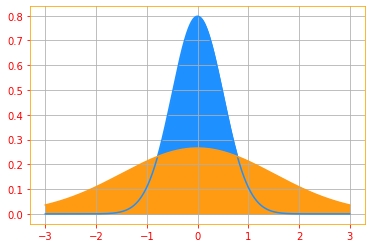

In [ ]:
# creating an x axis from -3 to 3 with 0.001 increments
x_axis = tf.range(-3, 3, 0.001)

# Let's create two distributions to see how variance affects the distributions. loc(=mean) and std.deviation(=scale)
distribution_1 = tfd.Normal(loc=0., scale=0.5)
distribution_2 = tfd.Normal(loc=0., scale=1.5)

# Distribution plot 1
plt.plot(x_axis, distribution_1.prob(x_axis), color=color_b)
plt.fill_between(x_axis, distribution_1.prob(x_axis), color=color_b)

# Distribution plot 2
plt.plot(x_axis, distribution_2.prob(x_axis), color=color_o)
plt.fill_between(x_axis, distribution_2.prob(x_axis), color=color_o)
plt.grid()

print("Blue Plot Variance: {} \nOrange Plot Variance: {}".format(distribution_1.variance(), distribution_2.variance()))

The __covariance__ gives some sense of how much two values are linearly related to each other, as well as the scale of these variables:

$$\color{orange}{Cov(f(x), g(y)) = \mathbb{E} \big[ (f(x) - \mathbb{E}[f(x)]) (g(y) - \mathbb{E}[g(y)]) \big] \tag{11}}$$

In simple terms covariance refers to the measure of how two random variable in a data set will change together.

- High absolute values of the covariance mean that the values change very much and are both far from their respective means at the same time. 

- If the sign of the covariance is positive, then both variables tend to take on relatively high values simultaneously. 

- If the sign of the covariance is negative, then one variable tends to take on a relatively high value at the times that the other takes on a relatively low value and vice versa.

In [ ]:
"""
To find the covariance we will be using another tensorflow probability library called the stats.
"""

# We start by creating two normal distributions to represent f(x) and g(y)
f_x = tf.random.normal(shape=(100, 1, 3))
g_y = tf.random.normal(shape=(100, 1, 3))

# cov[i, j] is the sample covariance between fx[:, i, j] and fy[:, i, j].
covariance = tfp.stats.covariance(f_x, g_y, sample_axis=0, event_axis=None)

print("Covariance of f(x) and g(y): {}".format(covariance[0]))

Covariance of f(x) and g(y): [-0.0710052   0.02556204  0.17078571]


Sometimes we confuse covariance with __correlation__, even though they both indicate whether variables are positively or negatively related to each other, they defer from the fact that covariance only determines whether the different units of the variables are increasing or decreasing, while correlation measures how closely the variables move together by normalizing the contribution of each variable.

In [ ]:
# correlation of f(x)
correlation = tfp.stats.correlation(f_x, g_y, sample_axis=0, event_axis=None)

print("Correlation of f(x) and g(y): {}".format(correlation[0]))


Correlation of f(x) and g(y): [-0.06961168  0.03230958  0.14600098]


The notions of covariance and dependence are related but distinct concepts. They are related because two variables that are independent have zero covariance, and two variables that have nonzero covariance are dependent. 

Independence, however, is a distinct property from covariance. For two variables to have zero covariance, there must be no linear dependence between them. Independence is a stronger requirement than zero covariance, because independence also excludes nonlinear relationships. 

The __covariance matrix__ of a random vector $x \in \mathbb{R}^n$ is an *n x n* matrix, such that:

$$\color{orange}{Cov(\mathbf{x})_{i, j} = Cov(\mathrm{x}_i, \mathrm{x}_j) \tag{12}}$$

The diagonal elements of the covariance give the variance:

$$\color{orange}{ Cov(\mathrm{x}_i, \mathrm{x}_j) = Var(\mathrm{x}_i) \tag{13}}$$

In [ ]:
# covariance matrix of f(x)
cov_matrix = tfp.stats.covariance(f_x, sample_axis=0, event_axis=-1)

print("Variance of x: {} \nCovariance Matrix for x: \n{}".format(covariance[0], cov_matrix[0]))

Variance of x: [-0.0710052   0.02556204  0.17078571] 
Covariance Matrix for x: 
[[ 1.0937256  -0.02701358  0.272605  ]
 [-0.02701358  0.7084776   0.07274828]
 [ 0.272605    0.07274828  1.4087355 ]]


# 03.09 - Common Probability Distributions

A probability distribution is a function that describes how likely you will obtain the different possible values of the random variable.

Following are a few examples of popular distributions.

## 3.9.1 Bernoulli Distribution

The __Bernoulli distribution__ is a distribution over a single binary random variable. It is controlled by a single parameter $\phi \in [0, 1]$, which gives the probability of the random variable being equal to 1. It has the following properties:

$$
\color{orange}{P(\mathrm{x} = 1) = \phi} \\
\color{orange}{P(\mathrm{x} = 0) = 1 - \phi} \\
\color{orange}{P(\mathrm{x} = x) = \phi^x (1 - \phi)^{1-x}} \\
\color{orange}{\mathbb{E}_{\mathrm{x}} [\mathrm{x}] = \phi}\\
\color{orange}{ Var_{\mathrm{x}}(\mathrm{x}) = \phi(1 - \phi) \tag{14}}
$$

The Bernoulli distribution is a special case of the __Binomial distribution__ where there is only one trial. A binomial distribution is the sum of independent and identically distributed Bernoulli random variables. For example, let's say you do a single coin toss, the probability of getting heads is p. The random variable that represents your winnings after one coin toss is a Bernoulli random variable. So, what is the probability that you land heads in 100 tosses, this is where you use the Bernoulli trials, in general, if there are n Bernoulli trials, then the sum of those trials is a binomial distribution with parameters n and p. Below, we will see an example for 1000 trials and the resulting Binomial distribution is plotted.


P(x = 1) = 0.5
P(x = 0) = 1 - 0.5 = 0.5
Property three is a generalization of property 1 and 2
For Bernoulli distribution The expected value of a Bernoulli random variable  X is p (E[X] = p)
Var(x) = 0.25 (1 - 0.25)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


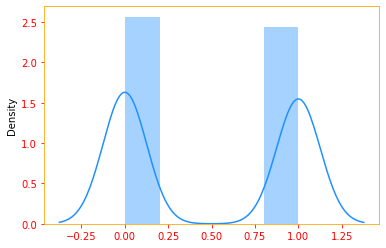

In [ ]:
# Create a Bernoulli distribution with a probability .5 and sample size of 1000
bernoulli_distribution = tfd.Bernoulli(probs=.5)
bernoulli_trials = bernoulli_distribution.sample(1000)

# Plot Bernoulli Distribution
sns.distplot(bernoulli_trials, color=color_b)

# Properties of Bernoulli distribution
property_1 = bernoulli_distribution.prob(1)
print("P(x = 1) = {}".format(property_1))

property_2 = bernoulli_distribution.prob(0)
print("P(x = 0) = 1 - {} = {}".format(property_1, property_2))

print("Property three is a generalization of property 1 and 2")

print("For Bernoulli distribution The expected value of a Bernoulli random variable  X is p (E[X] = p)")

# Variance is calculated as Var = E[(X - E[X])**2]
property_5 = bernoulli_distribution.variance()
print("Var(x) = {0} (1 - {0})".format(property_5))

## 3.9.2 Multinoulli Distribution

The __multinoulli__ or __categorical distribution__ is a distribution over a single discrete variable with *k* different states, where *k* is finite. The multinoulli distribution is a special case of the __multinomial distribution__, which is a generalization of Binomial distribution. A multinomial distribution is the distribution over vectors in ${0, \cdots, n}^k$ representing how many times each of the *k* categories visited when *n* samples are drawn from a multinoulli distribution. 

[0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Dice throw values: [[ 9. 13.  7. 11. 10. 10.]]
In sixty trials, index 0 represents the times the dice landed on 1 (= 9.0 times) and 
index 1 represents the times the dice landed on 2 (= 13.0 times)



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


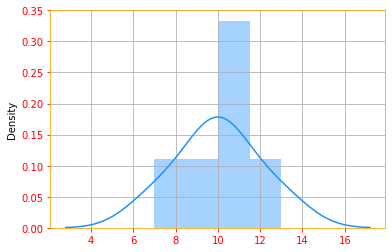

In [ ]:
# For a fair dice
p = [1/6.]*6
print(p)
# Multinoulli distribution with 60 trials and sampled once
multinoulli_distribution = tfd.Multinomial(total_count=60., probs=p)
multinoulli_pdf = multinoulli_distribution.sample(1)

print("""Dice throw values: {}
In sixty trials, index 0 represents the times the dice landed on 1 (= {} times) and 
index 1 represents the times the dice landed on 2 (= {} times)\n""".format(multinoulli_pdf, 
                                                                           multinoulli_pdf[0][0], 
                                                                           multinoulli_pdf[0][1]))

g = sns.distplot(multinoulli_pdf, color=color_b)
plt.grid()

There are other discrete distributions like:
- Hypergeometric Distribution: models sampling without replacement
- Poisson Distribution: expresses the probability of a given number of events occurring in a fixed interval of time and/or space if these events occur with a known average rate and independently of the time since the last event.
- Geometric Distribution:  counts the number of Bernoulli trials needed to get one success.

Since this will not be an exhaustive introduction to distributions, I presented only the major ones and for the curious ones, if you want to learn more, you can take a look at the references I mention at the end of the notebook.

Next, we will take a look at some continuous distributions.


## 3.9.3 Gaussian Distribution

The most commonly used distribution over real numbers is the __normal distribution__, also known as the __Gaussian distribution__:

$$\color{orange}{\mathcal{N}(x; \mu, \sigma^2) = \sqrt{\frac{1}{2 \pi \sigma^2}} exp \Big(- \frac{1}{2 \sigma^2} (x - \mu)^2 \Big) \tag{15}}$$

The two parameters $\mu \in \mathbb{R}$ and $\sigma \in (0, \infty)$ control the normal distribution. The parameter $\mu$ gives the coordinate of the central peak. This is also the mean of the distribution: $\mathbb{E}[\mathrm{x}] = \mu$. The standard deviation of the distribution is given by $\sigma$, and the variance by $\sigma^2$.

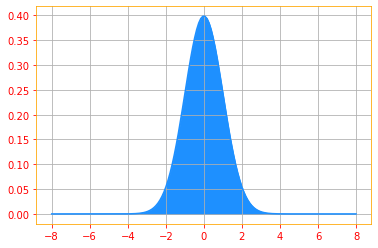

In [ ]:
# We use linespace to create a range of values starting from -8 to 8 with incremants (= stop - start / num - 1)
rand_x= tf.linspace(start=-8., stop=8., num=150)

# Gaussian distribution with a standard deviation of 1 and mean 0
sigma = float(1.)
mu = float(0.)
gaussian_pdf = tfd.Normal(loc=mu, scale=sigma).prob(rand_x)

# convert tensors into numpy ndarrays for plotting
[rand_x_, gaussian_pdf_] = evaluate([rand_x, gaussian_pdf])

# Plot of the Gaussian distribution
plt.plot(rand_x_, gaussian_pdf_, color=color_b)
plt.fill_between(rand_x_, gaussian_pdf_, color=color_b)
plt.grid()

Normal distributions are a sensible choice for many applications. In the absence of prior knowledge about what form a distribution over the real numbers should take, the normal distribution is a good default choice for two major reasons.

1. Many distributions we wish to model are truly close to being normal distributions. The __central limit theorem__ shows that the sum of many independent random variables is approximately normally distributed.
2. Out of all possible probability distributions with the same variance,
the normal distribution encodes the maximum amount of uncertainty over the real numbers. We can thus think of the normal distribution as being the one that inserts the least amount of prior knowledge into a model.

The normal distribution generalizes to $\mathbb{R}^n$, in which case it is known as the __multivariate normal distribution__. It may be parameterized with a positive definite symmetric matrix $\Sigma$:

$$\color{orange}{\mathcal{N}(x; \mu, \Sigma) = \sqrt{\frac{1}{(2 \pi)^n det(\Sigma)}} exp \Biggr(- \frac{1}{2} (x - \mu)^\top \Sigma^{(-1)} (x - \mu) \Biggr) \tag{16}}$$

The parameter $\mu$ still gives the mean of the distribution, though now it is vector valued. The parameter $\Sigma$ gives the covariance matrix of the distribution.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


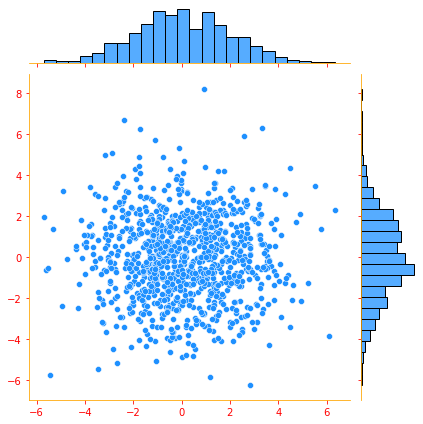

In [ ]:
# We create a multivariate normal distribution with two distributions with mean 0. and std.deviation of 2.
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag = [2., 2.])

# we take 1000 samples from the distribution
samples = mvn.sample(1000)

# Plot of multi variate distribution
g = sns.jointplot(samples[:, 0], samples[:, 1], kind='scatter', color=color_b)
plt.show()

## 3.9.6 Mixtures of Distributions

One common way of combining simpler distributions to define probability distribution is to construct a __mixture distribution__. A mixture distribution is made up of several component distributions. On each trial, the choice of which component distribution should generate the sample is determined by sampling a component identity from a multinoulli distribution:

$$\color{orange}{P(\mathrm{x}) = \displaystyle\sum_i P(c = i) \ P(\mathrm{x} | c = i) \tag{21}}$$

where $P(c)$ is the multinoulli distribution over component identities.

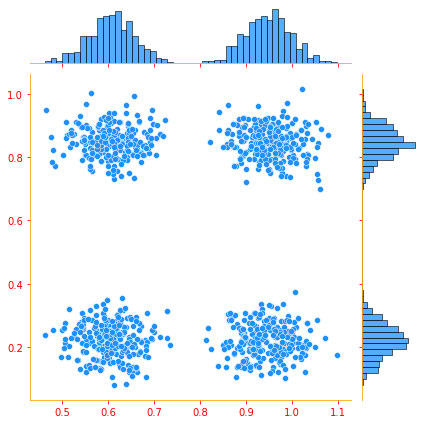

In [ ]:
"""
We will be creating two variable with two components to plot the mixture of distributions.

The tfd.MixtureSameFamily distribution implements a batch of mixture distribution where all components are from 
different parameterizations of the same distribution type. In our example, we will be using tfd.Categorical to
manage the probability of selecting components. Followed by tfd.MultivariateNormalDiag as components. 
The MultivariateNormalDiag constructs Multivariate Normal distribution on R^k
"""

num_vars = 2        # Number of variables (`n` in formula).
var_dim = 1         # Dimensionality of each variable `x[i]`.
num_components = 2  # Number of components for each mixture (`K` in formula).
sigma = 5e-2        # Fixed standard deviation of each component.

# Set seed.
tf.random.set_seed(77)

# categorical distribution
categorical = tfd.Categorical(logits=tf.zeros([num_vars, num_components]))

# Choose some random (component) modes.
component_mean = tfd.Uniform().sample([num_vars, num_components, var_dim])

# component distribution for the mixture family
components = tfd.MultivariateNormalDiag(loc=component_mean, scale_diag=[sigma])

# create the mixture same family distribution
distribution_family = tfd.MixtureSameFamily(mixture_distribution=categorical, components_distribution=components)

# Combine the distributions
mixture_distribution = tfd.Independent(distribution_family, reinterpreted_batch_ndims=1)

# Extract a sample from the distribution
samples = mixture_distribution.sample(1000).numpy()

# Plot the distributions
g = sns.jointplot(x=samples[:, 0, 0], y=samples[:, 1, 0], kind="scatter", color=color_b, marginal_kws=dict(bins=50))
plt.show()

The mixture model allows us to briefly glimpse a concept that will be of paramount importance later—the __latent variable__. A latent variable is a random variable that we cannot observe directly. Latent variables may be related to x through the joint distribution.

A very powerful and common type of mixture model is the __Gaussian mixture model__, in which the components $p(\mathrm{x} | c =i)$ are Gaussians. Each component has a separate parametrized mean $\mu^{(i)}$ and covariance $\Sigma^{(i)}$. As with a single Gaussian distribution, the mixture of Gaussians might constrain the covariance matrix for each component to be diagonal or isotropic. A Gaussian mixture model is a __universal approximator__ of densities, in the sense that any smooth density can be approximated with any specific nonzero amount of error by a Gaussian mixture model with enough components.

Some of the other continuous distribution functions include:
- Erlang Distribution: In a Poisson process of rate $\lambda$ the waiting times between k events have an Erlang distribution.
- Gamma Distribution: In a Poisson process with rate $\lambda$  the gamma distribution gives the time to the $k^{th}$ event.
- Beta Distribution: represents a family of probabilities and is a versatile way to represent outcomes for percentages or proportions.
- Dirichlet Distribution: is a multivariate generalization of the Beta distribution. Dirichlet distributions are commonly used as prior distributions in Bayesian statistics.

I recommend you go back to some of the examples before section 9 to see how we are using these distributions to understand how these are applied.

# 03.10 - Useful Properties of Common Functions

Logistic Sigmoid:

$$\color{orange}{\sigma(x) = \frac{1}{1 + exp(-x)} \tag{22}}$$

The logistic sigmoid is commonly used to produce the $\phi$ parameter of a Bernoulli distribution because its range is (0, 1), which lies within the valid range of values for the $\phi$ parameter. The sigmoid function saturates when its argument is very positive or very negative, meaning that the function becomes very flat and insensitive to small changes in its input.


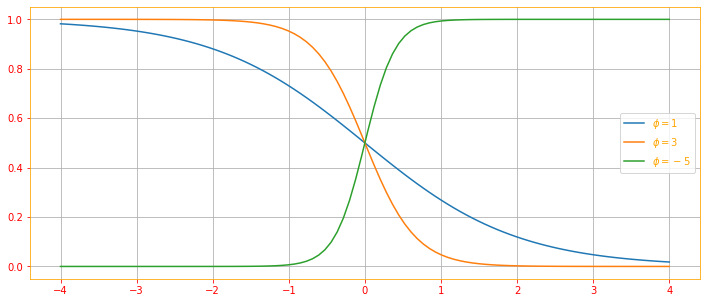

In [ ]:
def logistic(x, phi):
    """Calculates the logistic function.
    Arguments:
        x (int)      : is the x values.
        phi (int)    : parameter.
    Returns:
        Values in range(0, 1)
    """
    return 1.0 / (1.0 + tf.exp(phi * x))

# create a range of values starting from -4 to 4 with incremants (= stop - start / num - 1)
x_vals = tf.linspace(start=-4., stop=4., num=100)

# Create three logistic functions to see the effect of the parameter phi
log_phi_1 = logistic(x_vals, 1.)
log_phi_3 = logistic(x_vals, 3.)
log_phi_5 = logistic(x_vals, -5.)

# convert tensors into numpy ndarrays for plotting
[x_vals_, log_phi_1_, log_phi_3_, log_phi_5_] = evaluate([x_vals, log_phi_1, log_phi_3, log_phi_5])

# Plot of the logistic function
plt.figure(figsize = (12, 5))
plt.plot(x_vals_, log_phi_1_, label=r"$\phi = 1$")
plt.plot(x_vals_, log_phi_3_, label=r"$\phi = 3$")
plt.plot(x_vals_, log_phi_5_, label=r"$\phi = -5$")
plt.legend()
plt.grid()

Softplus Function:

$$\color{orange}{\zeta (x) = log \ (1 + exp(x)) \tag{23}}$$

The softplus function can be useful for producing the $\beta$ or $\sigma$ parameter of a normal distribution because its range is (0, $\infty$). It also arises commonly when manipulating expressions involving sigmoids. The name of the softplus function comes from the fact that it is a smoothed, or “softened,” version of $x^+ = max(0, x)$

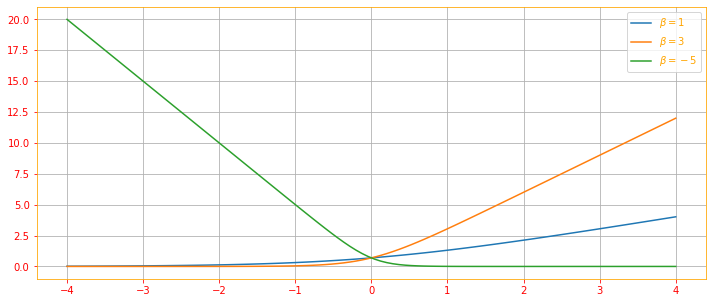

In [ ]:
def softplus(x, beta):
    """Calculates the softplus function.
    Arguments:
        x (int)        : is the number you want to calculate the probability for.
        beta (int)     : paramter.
    Returns:
        Values in range(0, infinity).
    """
    return tf.math.log(1 + tf.math.exp(beta * x))

# create a range of values starting from -4 to 4 with incremants (= stop - start / num - 1)
x_vals = tf.linspace(start=-4., stop=4., num=100)

# Create three softplus functions to see the effect of the parameter beta
log_beta_1 = softplus(x_vals, 1.)
log_beta_3 = softplus(x_vals, 3.)
log_beta_5 = softplus(x_vals, -5.)

# convert tensors into numpy ndarrays for plotting
[x_vals_, log_beta_1_, log_beta_3_, log_beta_5_] = evaluate([x_vals, log_beta_1, log_beta_3, log_beta_5])

# Plot of the softplu function
plt.figure(figsize = (12, 5))
plt.plot(x_vals_, log_beta_1_, label=r"$\beta = 1$")
plt.plot(x_vals_, log_beta_3_, label=r"$\beta = 3$")
plt.plot(x_vals_, log_beta_5_, label=r"$\beta = -5$")
plt.legend()
plt.grid()

The following are some useful properties if you wish to memorize: 

![sigmoid and softplus properties](https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0310a.PNG)

The function $\sigma^{-1}x$ is called the __logit__ in statistics, but this term is rarely used in machine learning.

# 03.11 - Bayes' Rule

__Bayes' rule__ is a useful tool that computes the conditional probability $P( x | y)$ from $P(y | x)$. Here 

- $P( x | y)$ is called the _posterior_; this is what we are trying to estimate, 
- $P(y | x)$ is called the _likelihood_; this is the probability of observing the new evidence, given our initial hypothesis, 
- $P(x)$ is called the _prior_; this is the probability of our hypothesis without any additional prior information,
- $P(y)$ is called the _marginal likelihood_; this is the total probability of observing the evidence.

The Bayes' rule can be summed up as:

$$\color{orange}{P(x | y) = \frac{P(x) \ P(y | x)}{P(y)} \tag{24}}$$

Even though $P(y)$ appears in the formula, it is usually feasible to compute $P(y) = \sum_x P(y | x) P(x)$, so we do not need to begin with knowledge of $P(y)$.

In [ ]:
"""
There are 2 cookie jars:

Jar 1 has 30 vanilla cookies and 10 chocolate cookies
Jar 2 has 20 vanilla cookies and 20 chocolate cookies
You randomly pick one cookie from one randomly chosen jar. It is vanilla. What is the probability it was from Jar 1?

So we are looking for P(Jar 1 | Vanilla).
"""

# probability of picking between Jar 1 and 2: The Prior probability
p_jar_1 = 1/2

# Vanilla / total cookies: The likelihood
p_vanilla_given_jar_1 = 30/(30+10)

# total vanilla cookies / Total cookies: The marginal likelihood
p_vanilla = (30+20) / (30+10 + 20+20)

# Bayes' rule
p_jar_1_given_vanilla = (p_jar_1 * p_vanilla_given_jar_1) / p_vanilla

print('P(Jar 1 | Vanilla) = {}'.format(p_jar_1_given_vanilla))

P(Jar 1 | Vanilla) = 0.6


# 03.12 - Technical Details of Continuous Variables

In this section, we start with __Measure Theory__ and I would be giving you a no math introduction to it. The reason you aren't seeing any implementations is because most of the time these implementations are built directly into the tools you are using unless ofcourse if you are a researcher studying new types of data. So I won't be giving you any implementations but nevertheless this is an important area and understanding it may help you reformulate certain distribution problems.

Measure theory studies ways of generalizing the intuitive notions of length, area and volume. For example, see the image below:

![Measure Theory Example](https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0312a.jpg)

It's pretty challenging to see how we can measure the area of such a shape and that's in 2D and most of the time we are playing with higher dimensional data. Btw what do you see in the image, I see Darth Vader from star wars and I can't unsee it now 😂. Anyways, let's see how measure theory can help in such situations. 

For example, let's say you want to measure how long it would take for you to read the [Deep Learning with Tensorflow 2.0](https://www.adhiraiyan.org/DeepLearningWithTensorflow.html) book. What would be a good measure? If you go by using the number of pages, would that be a good metric? Because pages of a book would differ if it was printed in hardcover, paperback or in our case an ebook, so if you take this article, the read time you see on the top of the page is measured by the number of words, that is a good metric right, no matter hardcover, paperback or ebook, it would have the same number of words, so now, we do have version invariance between the different published formats, and if I want to add an extra chapter to this book, then I would just calculate the number of words in that chapter and add this to the book, this is the key contribution of measure theory.

Measure theory also provides a rigorous way of describing a set of points as negligibly small. Such a set is said to have __measure zero__. Let me explain this by continuing my book example, in this chapter and the rest, you see some pictures, and we can't measure the read time of pictures using words, so we set the pictures to have a measure zero and our read time based on words will still be a good approximation for the length of the book.

Another useful term from measure theory is __almost everywhere__. A property that holds almost everywhere holds throughout all space except for on a set of measure zero. Now this is where we generalize our measure, even though the example we saw had little probability, measure theory helps make certain probability statements precise.

Another technical detail of continuous variables relates to handling continuous random variables that are deterministic functions of one another. Suppose we have two random variables, __x__ and __y__, such that $y = g(x)$, where *g* is an invertible, continuous, differentiable transformation. One might expect that $p_y(y) = p_x(g^{-1}(y))$. This is not actually the case.

The problem with this approach is that it fails to account for the distortion of space introduced by the function *g*. Recall that the probability of $x$ lying in an infinitesimally small region with volume $\delta x$ is given by $p(x) \delta x$. Since *g* can expand or contract space, the infinitesimal volume surrounding $x$ in $x$ space may have different volume in $y$ space. We can correct this problem by defining:

$$\color{orange}{p_x(x) = p_y(g(x)) \Bigg|\frac{\partial g(x)}{\partial x} \Bigg| \tag{25}}$$

In higher dimensions, the derivative generalizes to the determinant of the __Jacobian matrix__- the matrix with $J_{i, j} = \frac{\partial{x}_i}{\partial{y}_j}$. Thus for real valued vectors $x$ and $y$:

$$\color{orange}{p_x(x) = p_y(g(x)) \Bigg| det \Big( \frac{\partial g(x)}{\partial x} \Big) \Bigg| \tag{26}}$$


# 03.13 - Information Theory

Information theory is a branch of applied mathematics that revolves around quantifying how much information is present in a signal. In the context of machine learning, we can also apply information theory to continuous variables where some of these message length interpretations do not apply. 

The basic intuition behind the information theory is that a likely event should have low information content, less likely events should have higher information content and independent events should have additive information.

Let me give you a simple example, lets say you have a male friend, and he is head over heels in love with this girl, so he asks this girl out pretty much every week and there's a 99% chance she says no, so you being his best friend, he texts you everytime after he asks the girl out to let you know what happened, he texts, "Hey guess what she said, NO 😭😭😭", this is of course wasteful, considering he has a very low chance so it makes more sense for your friend to just send "😭" but if she says yes then he can of course send a longer text, so this way, the number of bits used to convey the message (and your corresponding data bill) will be minimized. P.S don't tell your friend he has a low chance, that's how you lose friends 😬.

To satisfy these properties, we define the __self-information__ of an event $\mathrm{x} = x$ to be:

$$\color{orange}{I(x) = -log \ P(x) \tag{27}}$$

In this book, we always use log to mean the natural logarithm, with base e. Our definition of $I(x)$ is therefore written in units of __nats__. One nat is the amount of information gained by observing an event of probability $\frac{1}{e}$. Other texts use base-2
logarithms and units called __bits__ or __shannons__; information measured in bits is just a rescaling of information measured in nats.

Entropy of 10 coin tosses in nats: 0.6931471824645996 
For tosses: [1 0 0 0 0 0 1 1 0 1]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


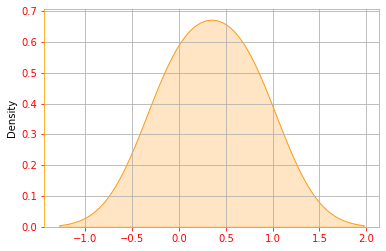

In [ ]:
"""
No matter what combination of toss you get the Entropy remains the same but if you change the probability of the
trial, the entropy changes, play around with the probs and see how the entropy is changing and see if the increase
or decrease makes sense.
"""

coin_entropy = [0]                                                                     # creating the coin entropy list

for i in range(10, 11):
    coin = tfd.Bernoulli(probs=0.5)                                                    # Bernoulli distribution 
    coin_sample = coin.sample(i)                                                       # we take 1 sample
    coin_entropy.append(coin.entropy())                                                # append the coin entropy
    sns.distplot(coin_entropy, color=color_o, hist=False, kde_kws={"shade": True})     # Plot of the entropy

print("Entropy of 10 coin tosses in nats: {} \nFor tosses: {}".format(coin_entropy[1], coin_sample))
plt.grid()

Self information deals only with a single outcome. We can quantify the amount of uncertainty in an entire probability distribution using the __Shannon entropy__:

$$\color{orange}{H(\mathrm{x}) = \mathbb{E}_{x \sim P} [I(x)] = -\mathbb{E}_{x \sim P}[log \ P(x)] \tag{28}}$$

also denoted as $H(P)$.

Shannon entropy of a distribution is the expected amount of information in an event drawn from that distribution. It gives a lower bound on the number of bits needed on average to encode symbols drawn from a distribution P. Distributions that are nearly deterministic (where the outcome is nearly certain) have low entropy; distributions that are closer to uniform have high entropy. When $\mathrm{x}$ is continuous, the Shannon entropy is known as the __differential entropy__.

In [ ]:
"""
Note here since we are using the Bernoulli distribution to find the expectation we simply use mean, 
if you change the distribution, you need to find the Expectation accordingly
"""

def shannon_entropy_func(p):
    """Calculates the shannon entropy.
    Arguments:
        p (int)        : probability of event.
    Returns:
        shannon entropy.
    """
    
    return -tf.math.log(p.mean())

# Create a Bernoulli distribution
bernoulli_distribution = tfd.Bernoulli(probs=.5)

# Use TFPs entropy method to calculate the entropy of the distribution
shannon_entropy = bernoulli_distribution.entropy()

print("TFPs entropy: {} matches with the Shannon Entropy Function we wrote: {}".format(shannon_entropy, 
                                                                                       shannon_entropy_func(bernoulli_distribution)))

TFPs entropy: 0.6931471824645996 matches with the Shannon Entropy Function we wrote: 0.6931471824645996


Entropy isn't remarkable for its interpretation, but for its  properties. For example, entropy doesn't care about the actual *x* values like variance, it only considers their probability. So if we increase the number of values *x* may take then the entropy will increase and the probabilities will be less concentrated.

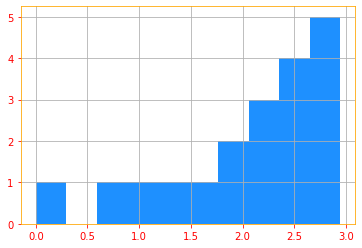

In [ ]:
# You can see below by changing the values of x we increase the entropy

shannon_list = []

for i in range(1, 20):
    uniform_distribution = tfd.Uniform(low=0.0, high=i)    # We create a uniform distribution
    shannon_entropy = uniform_distribution.entropy()       # Calculate the entropy of the uniform distribution
    shannon_list.append(shannon_entropy)                   # Append the results to the list

# Plot of Shannon Entropy
plt.hist(shannon_list, color=color_b)
plt.grid()

If we have two separate probability distributions P(x) and Q(x) over the same random variable x, we can measure how different these two distributions are using the __Kullback-Leibler (KL) divergence__:

$$\color{orange}{D_{KL} (P \| Q) = \mathbb{E}_{x \sim P} \Big[ log \ \frac{P(x)}{Q(x)} \Big] = \mathbb{E}_{x \sim P} [log \ P(x) - log \ Q(x)] \tag{29}}$$

In the case of discrete variables, it is the extra amount of information needed to send a message containing symbols drawn from probability distribution P, when we use a code that was designed to minimize
the length of messages drawn from probability distribution Q.




In [ ]:
def kl_func(p, q):
    """Calculates the KL divergence of two distributions.
    Arguments:
        p    : Distribution p.
        q    : Distribution q.
    Returns:
        the divergence value.
    """
    
    r = p.loc - q.loc
    return (tf.math.log(q.scale) - tf.math.log(p.scale) -.5 * (1. - (p.scale**2 + r**2) / q.scale**2))

# We create two normal distributions
p = tfd.Normal(loc=1., scale=1.)
q = tfd.Normal(loc=0., scale=2.)

# Using TFPs KL Divergence
kl = tfd.kl_divergence(p, q)

print("TFPs KL_Divergence: {} matches with the KL Function we wrote: {}".format(kl, kl_func(p, q)))

TFPs KL_Divergence: 0.4431471824645996 matches with the KL Function we wrote: 0.4431471824645996


The KL divergence has many useful properties, most notably being nonnegative. The KL divergence is 0 if and only if P and Q are the same distribution in the case of discrete variables, or equal “almost everywhere” in the case of continuous variables.

A quantity that is closely related to the KL divergence is the __cross-entropy__ $H(P, Q) = H(P) + D_{KL} (P \| Q)$, which is similar to the KL divergence but lacking the term on the left:

$$\color{orange}{H(P, Q) = - \mathbb{E}_{x \sim P} \ log \ Q(x) \tag{30}}$$

Minimizing the cross-entropy with respect to Q is equivalent to minimizing the KL divergence, because Q does not participate in the omitted term.

In [ ]:
"""
The cross_entropy computes the Shannons cross entropy defined as:
H[P, Q] = E_p[-log q(X)] = -int_F p(x) log q(x) dr(x)
"""

# We create two normal distributions
p = tfd.Normal(loc=1., scale=1.)
q = tfd.Normal(loc=0., scale=2.)

# Calculating the cross entropy
cross_entropy = q.cross_entropy(p)

print("TFPs cross entropy: {}".format(cross_entropy))

TFPs cross entropy: 3.418938636779785


# 03.14 - Structured Probabilistic Models

Machine learning algorithms often involve probability distributions over a very large number of random variables. Often, these probability distributions involve direct interactions between relatively few variables. Using a single function to describe the entire joint probability distribution can be very inefficient (both computationally and statistically). 

Insted of using a single function to represent a probabiility distribuiton, we can split a probability distribution into many factors that we multiply together. These factorizations can greatly reduce the number of parameters needed to describe the distribution.

We can describe these kinds of factorizations using graphs. Here, we use the word “graph” in the sense of graph theory: a set of vertices that may be connected to each other with edges. When we represent the factorization of a probability distribution with a graph, we call it a __structured probabilistic model__, or __graphical model__.

![Graphical Theory Intro](https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0314a.jpeg)

If you haven't noticed, I am not that artsy, the image above is from Vaidehi Joshi's Medium post.


There are two main kinds of structured probabilistic models: directed and undirected. Both kinds of graphical models use a graph $\mathcal{G}$ in which each node in the graph corresponds to a random variable, and an edge connecting two random variables means that the probability distribution is able to represent direct interactions between those two random variables. 

__Directed__ models or __Directed Acyclic Graphs (DAG)__ also known as __Bayesian Network__ use graphs with directed edges, these edges give _casuality_ relationships and they represent factorizations into conditional probability distributions. Specifically, a directed model contains one factor for every random variable $\mathrm{x}_i$ in the distribution, and that factor consists of the conditional distribution over $\mathrm{x}_i$ given the parents of $\mathrm{x}_i$ denoted $Pa_{\mathcal{G}}(\mathrm{x}_i)$

$$\color{orange}{p(\mathrm{x}) = \prod_i p(\mathrm{x}_i \ | \ Pa_{\mathcal{G}}(\mathrm{x}_i)) \tag{31}}$$

![Directed graph example](https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0314b.PNG)

This graph corresponds to probability distributions that can be factored as: 

$p(a, b, c, d, e) = p(a) p(b | a) p(c | a, b) p(d | b) p(e | c)$

An application of directed graph is in finding who is related to who, for example, take Dr. Who, haha, that wasn't on purpose:

![Directed graph example dr who](https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0314d.png)

I don't watch the show so, have no clue who these people are but looking at the graph, there are some bad people and how one is related to another is quite clear. You can also think of social networks, like twitter, if you put all your followers and people who you follow, what you get would be a directed graph.



__Undirected__ models or __Undirected Graphical Models (UGM)__ also known as __Markov Random Fields__ use graphs with undirected edges, these edges give _correlations_ between variables and they represent factorization into a set of functionals unlike in the directed case, these functions are usually not probability distributions of any kind. Any set of nodes that are all connected to each other in $\mathcal{G}$ is called a clique. Each clique $\mathcal{C}^{(i)}$ in an undirected model is associated with a factor $\phi^{(i)} (\mathcal{C^(i)})$. These factors are just functions, not probability distributions. The output of each factor must be non-negative, but there is no constraint that the factor must sum or integrate to 1 like a probability distribution.

The probability of a configuration of random variables is proportional to the product of all these factors and since there is no guarantee that this product will sum to 1, we divide by a normalizing constant $Z$, defined to be the sum or integral over all states of the product of the $\phi$ functions, in order to obtain a normalized probability distribution:

$$\color{orange}{p(x) = \frac{1}{Z} \prod_i \phi^{(i)} (\mathcal{C}^{(i)}) \tag{32}}$$

![Undirected graph example](https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0314c.PNG)

This graph corresponds to probability distributions that can be factored as:

$p(a, b, c, d, e) = \frac{1}{Z} \phi^{(1)} (a, b, c) \phi^{(2)} (b, d) \phi^{(3)} (c, e)$

An application of undirected graph is in social network analysis, like facebook:

![Undirected graph example facebook](https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0314e.png)

Some of the other example include, protein interaction networks, modeling the game Go and information retrieval.


Keep in mind that being directed or undirected is not a property of a probability distribution, it is a property of a particular description of a probability distribution, but any probability distribution may be described in both ways.

This is another section we did not go through any practical examples and the reason is we will go through these concepts in much detail in the upcoming chapters and providing implementations to these models now require us to go through some of the concepts that we will see later, for now, what you have above is enough to get a good introduction and intuition for probabilistic models and we will go deeper into it in the future sections, for now a good mystery is always good right 😉.

# 💫 Congratulations

You have successfully completed Chapter 3 Probability and Information Theory of [Deep Learning with Tensorflow 2.0](https://www.adhiraiyan.org/DeepLearningWithTensorflow.html). To recap, we went through the following concepts:

- Why Probability?
- Random Variables
- Probability Distributions
- Marginal Probability
- Conditional Probability
- The Chain Rule of Conditional Probabilities
- Independence and Conditional Independence
- Expectation, Variance and Covariance
- Common Probability Distributions
- Useful Properties of Common Functions
- Bayes' Rule
- Technical Details of Continuous Variables
- Information Theory
- Structured Probabilistic Models

If you like to go through a more comprehensive probability book that takes you through all the basics and little bit of information theory, I recommend [The Art Of Probability by Hamming](https://www.amazon.com/Art-Probability-Richard-W-Hamming/dp/0201406861/ref=mt_paperback?_encoding=UTF8&me=) (you can find a free version online 😉) or [Introduction to Probability by Bertsekas and Tsitsiklis.](https://www.amazon.com/Introduction-Probability-2nd-Dimitri-Bertsekas/dp/188652923X/ref=dp_ob_title_bk).

This chapter has reviewed the basic concepts of probability theory that are most relevant to deep learning. One more set of fundamental mathematical tools remains: numerical methods.

<!--NAVIGATION-->
< [02.00 - Linear Algebra](02.00-Linear-Algebra.ipynb) | [Contents](Index.ipynb) | [04.00 - Numerical Computation](04.00-Numerical-Computation.ipynb) >

<a href="https://colab.research.google.com/github/adhiraiyan/DeepLearningWithTF2.0/blob/master/notebooks/03.00-Probability-and-Information-Theory.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
